Current Forward Value: 6.5994e-04
MarketStrikes: [-0.00434006 -0.00184006 -0.00059006  0.00065994  0.00190994  0.00315994
  0.00565994  0.01065994  0.01565994]
ATM Shifted Black Volatility: [0.14]
            Shift               Alpha  Beta       Rho        Nu
1Y into 5Y   0.01  0.013916+0.000000j   0.5  0.275937  0.691765


c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_lsq\trf.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  f_augmented[:m] = f
c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_lsq\trf.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  J_augmented[m:] = np.diag(diag_h**0.5)
c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginar

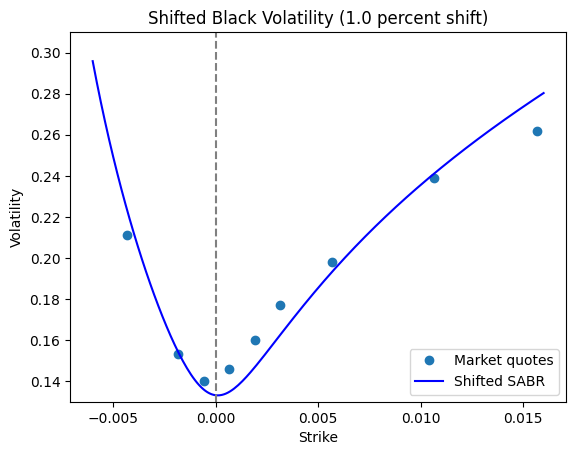

In [14]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.stats import norm


valuation_date = pd.to_datetime('5-Apr-2016', format='%d-%b-%Y')
months = [1, 2, 3, 6, 9] + [12 * i for i in range(1, 11)]

# On calcule les dates de fin en ajoutant des months à valuation_date
end_dates = [valuation_date + DateOffset(months=m) for m in months]
end_dates_days = [(date - valuation_date).days for date in end_dates]

# Data zero rates
zero_rates = np.array([-0.33, -0.28, -0.24, -0.12, -0.05, 0.00, 0.015, 0.03, 0.035, 0.045, 0.055, 0.095, 0.195, 0.295, 0.415]) / 100


# On créer un dataframe avec les spec
rate_spec = pd.DataFrame({
    'ValuationDate': [valuation_date] * len(end_dates),
    'StartDates': [valuation_date] * len(end_dates),
    'EndDates': end_dates,
    'EndDatesDays': end_dates_days,
    'Rates': zero_rates,
    'Compounding': [1] * len(end_dates)
})

# Fonction pour calculer le forward swap rate
def swapbyzero(rate_spec, leg_rate, settle_date, maturity_date, start_date):
    
    zero_rates = rate_spec['Rates'].values
    end_dates_days = rate_spec['EndDatesDays'].values
    
    
    settle_days = (settle_date - valuation_date).days
    start_days = (start_date - valuation_date).days
    maturity_days = (maturity_date - valuation_date).days
    
    # Interpolation linéaire des données si besoin 
    interpolator = interp1d(end_dates_days, zero_rates, kind='linear', fill_value="extrapolate")
    
    def calculate_forward_rate(start_days, maturity_days, zero_rates, end_dates_days): 
        zero_rate_start = interpolator(start_days)
        zero_rate_end = interpolator(maturity_days)
        
        # Calcul du forward rate 
        t1 = start_days / 365.25
        t2 = maturity_days / 365.25
        forward_rate = (zero_rate_end * t2 - zero_rate_start * t1) / (t2 - t1)
        
        return forward_rate
    
    # Calcul du forward swap rate
    forward_rate = calculate_forward_rate(start_days, maturity_days, zero_rates, end_dates_days)
    
    return forward_rate


swaption_exercise_date = pd.to_datetime('5-Apr-2017', format='%d-%b-%Y')
swap_maturity = pd.to_datetime('5-Apr-2022', format='%d-%b-%Y')

leg_rate = [np.nan, 0]

current_forward_value = swapbyzero(rate_spec, leg_rate, valuation_date, swap_maturity, swaption_exercise_date)
print(f"Current Forward Value: {current_forward_value:.4e}") 


MarketShiftedBlackVolatilities = np.array([20.0, 14.0, 13.5, 14.0, 15.0, 17.0, 19.0, 22.0, 25.0]) / 100



# On définit le shift de notre modèle Shifted SABR
Shift = 0.010

StrikeGrid = np.array([-0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.8, 1.2])/100

# MarketStrikes = current_forward_value + StrikeGrid + Shift

ATMShiftedBlackVolatility = MarketShiftedBlackVolatilities[StrikeGrid == 0]

print("MarketStrikes:", MarketStrikes)
print("ATM Shifted Black Volatility:", ATMShiftedBlackVolatility)





# Market Data
CurrentForwardValue = current_forward_value  

TimeToExercise = 1  
SwaptionMaturity = 5  


def sabr_volatility(alpha, beta, rho, nu, f, k, t, shift):
    f_shifted = f + shift
    k_shifted = k + shift
    
    if f_shifted == k_shifted: # Dans le cas ATM
        z = nu / alpha * (f_shifted ** (1 - beta)) * np.sqrt(t)
        x_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
        return alpha * (f_shifted ** (beta - 1)) * (1 + ((1 - beta) ** 2 / 24 * (np.log(f_shifted/k_shifted))**2 + (1 - beta)**4 / 1920 * (np.log(f_shifted/k_shifted))**4) * z / x_z)
    else: # Cas non ATM
        z = nu / alpha * (f_shifted * k_shifted) ** ((1 - beta) / 2) * np.log(f_shifted / k_shifted)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
        return alpha / ((f_shifted * k_shifted) ** ((1 - beta) / 2)) * z / x_z * (1 + ((1 - beta) ** 2 / 24 * (np.log(f_shifted/k_shifted))**2 + (1 - beta)**4 / 1920 * (np.log(f_shifted/k_shifted))**4) * z / x_z)




ValuationDate = '5-Apr-2016'
SwaptionSettle = '5-Apr-2016'
SwaptionExerciseDate = '5-Apr-2017'
SwapMaturity = '5-Apr-2022'




MarketStrikes = CurrentForwardValue + StrikeGrid
ATMShiftedBlackVolatility = MarketShiftedBlackVolatilities[StrikeGrid==0][0]
Beta = 0.5


# Fonction pour déduire alpha 
def atm_vol_to_alpha(rho, nu):
    coeffs = [
        (1 - Beta)**2 * TimeToExercise / (24 * (CurrentForwardValue + Shift)**(2 - 2 * Beta)),
        rho * Beta * nu * TimeToExercise / (4 * (CurrentForwardValue + Shift)**(1 - Beta)),
        1 + (2 - 3 * rho**2) * nu**2 * TimeToExercise / 24,
        -ATMShiftedBlackVolatility * (CurrentForwardValue + Shift)**(1 - Beta)
    ]
    roots = np.roots(coeffs)
    alpha = np.min([root for root in roots if np.isreal(root) and root > 0])
    return alpha


def objective(params):
    rho, nu = params
    alpha = atm_vol_to_alpha(rho, nu)
    model_vols = np.array([sabr_volatility(alpha, Beta, rho, nu, CurrentForwardValue, k, TimeToExercise, Shift) for k in MarketStrikes])
    return MarketShiftedBlackVolatilities - model_vols


initial_guess = [0, 0.5]
bounds = ([-1, 0], [1, np.inf])

# Calibration 
result = least_squares(objective, initial_guess, bounds=bounds)
rho_calibrated, nu_calibrated = result.x
alpha_calibrated = atm_vol_to_alpha(rho_calibrated, nu_calibrated)


CalibratedParameters = pd.DataFrame({
    'Shift': [Shift],
    'Alpha': [alpha_calibrated],
    'Beta': [Beta],
    'Rho': [rho_calibrated],
    'Nu': [nu_calibrated]
}, index=['1Y into 5Y'])

print(CalibratedParameters)

# Market Data
MarketStrikes = CurrentForwardValue + np.array([-0.5, -0.25, -0.125, 0, 0.125, 0.25, 0.5, 1.0, 1.5])/100
MarketShiftedBlackVolatilities = np.array([21.1, 15.3, 14.0, 14.6, 16.0, 17.7, 19.8, 23.9, 26.2])/100


# On génère un range de strike en prenant aussi des négatifs 
Strikes = np.arange(-0.6, 1.61, 0.01)/100



# On calcule les SABR volatilités pour la range de strike définie, en utilisant nos paramètres calibrés
SABRShiftedBlackVolatilities = np.array([sabr_volatility(alpha_calibrated, Beta, rho_calibrated, nu_calibrated, CurrentForwardValue, k, TimeToExercise, Shift) for k in Strikes])



plt.figure()
plt.plot(MarketStrikes, MarketShiftedBlackVolatilities, 'o', label='Market quotes')
plt.plot(Strikes, SABRShiftedBlackVolatilities, label='Shifted SABR', color='blue')


plt.axvline(x=0, linestyle='--', color='grey')

plt.ylim(0.13, 0.31)
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.legend(loc='lower right')
plt.title(f'Shifted Black Volatility ({Shift*100} percent shift)')

# Show the plot
plt.show()

In [15]:
def shifted_black(F, K, T, r, sigma, Shift, Notional):
    d1 = (np.log((F + Shift) / (K + Shift)) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Discount factor 
    DF = np.exp(-r * T)
    
    # Formule d'une option call
    call_price_per_unit = DF * ((F + Shift) * norm.cdf(d1) - (K + Shift) * norm.cdf(d2))
    
    # Prise en compte du notional 
    call_price = call_price_per_unit * Notional
    
    return call_price

Notional = 800


Strikes = MarketStrikes
Volatilities = MarketShiftedBlackVolatilities


SwaptionPrices = np.array([shifted_black(CurrentForwardValue, K, TimeToExercise, 0, vol, Shift, Notional) 
                           for K, vol in zip(Strikes, Volatilities)])


plt.figure()
plt.plot(Strikes, SwaptionPrices, 'r', label='Shifted Black Swaption Prices')

# On ajoute une ligne verticale à 0
plt.axvline(x=0, linestyle='--', color='grey')

plt.xlabel('Strike')
plt.ylabel('Swaption Price')
plt.ylim(bottom=0)
plt.title(f'Swaption Price vs Strike with {Shift*100}% Shift')
plt.legend()
plt.show()


KeyboardInterrupt: 

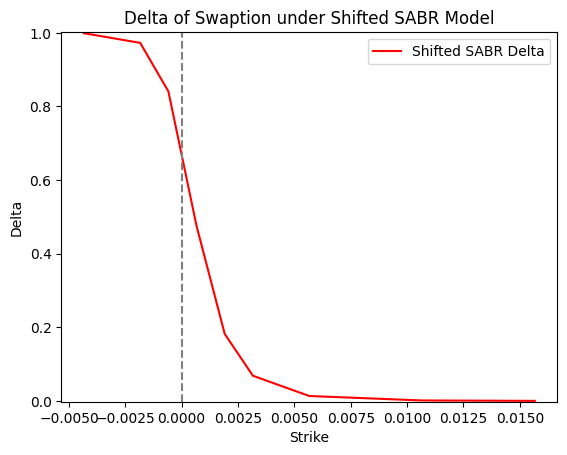

In [ ]:
# Paramètes calibrés
Alpha = alpha_calibrated
Rho = rho_calibrated
Nu = nu_calibrated

CurrentForwardValue = current_forward_value  
Strikes = MarketStrikes  

def shifted_black(F, K, T, sigma, shift):
    d1 = (np.log((F + shift) / (K + shift)) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (F + shift) * norm.cdf(d1) - (K + shift) * norm.cdf(d2)

def shifted_sabr_delta(alpha, beta, rho, nu, f, k, t, shift):
    epsilon = 1e-6
    sigma_up = sabr_volatility(alpha, beta, rho, nu, f + epsilon, k, t, shift)
    sigma_down = sabr_volatility(alpha, beta, rho, nu, f - epsilon, k, t, shift)
    price_up = shifted_black(f + epsilon, k, t, sigma_up, shift)
    price_down = shifted_black(f - epsilon, k, t, sigma_down, shift)
    return (price_up - price_down) / (2 * epsilon)


ShiftedSABRDelta = np.array([shifted_sabr_delta(Alpha, Beta, Rho, Nu, CurrentForwardValue, K, TimeToExercise, Shift) for K in Strikes])

# Plot the delta
plt.figure()
plt.plot(Strikes, ShiftedSABRDelta, 'r-', label='Shifted SABR Delta')
plt.ylim([-0.002, 1.002])

plt.axvline(x=0, linestyle='--', color='grey')
plt.xlabel('Strike')
plt.ylabel('Delta')
plt.title('Delta of Swaption under Shifted SABR Model')
plt.legend()
plt.show()

